# How to use `vcdisk`

This page demonstrates how to use `vcdisk` in typical use cases in Astronomy.

## What is `vcdisk`?

`vcdisk` uses the method of [Casertano (1983)](https://ui.adsabs.harvard.edu/abs/1983MNRAS.203..735C/) to solve Poisson's equation on the mid-plane of a thick axisymmetric galaxy disk. This is a fast and efficient way to compute the circular velocity of a stellar/gas disk with an arbitrary surface density distribution.

## Why do we need `vcdisk`?

The most typical use case for `vcdisk` is in rotation curve modelling. Specifically, this module allows to compute *the contribution to the circular velocity of the observed baryonic components of a disk galaxy*, e.g. the stellar disk, the gas disk, the stellar bulge.

If we have some kinematical observations that allowed us to measure the rotational velocities of some material in circular orbits in the disk of a spiral galaxy (e.g. cold gas), the observed rotation curve can be decomposed into several dynamically important components in the galaxy
![Rotation curve decomposition](vrot.png)
where $V_{\rm DM}$ is the contribution from dark matter, $V_{\star,\rm disk}$ from the stellar disk, $V_{\rm gas, disk}$ from the gas disk etc. 
While the left-hand side of this equation usually comes from observations, and the contribution of DM is the unknown that is often what we want to constrain, for all the other terms there is ``vcdisk``!

``vcdisk`` calculates the contribution to the gravitational field of an axisymmetric component whose radial surface density distribution is known. For instance, the surface density profiles of stellar ($\Sigma_{\star, \rm disk}$) and gaseous disks ($\Sigma_{\star, \rm disk}$) can be directly obtained from galaxy images in appropriate wavebands and these can then be used as input for ``vcdisk`` to calculate $V_{\rm disk}(R, \Sigma_{\rm disk}(R))$.

While the method of Casertano (1983) is designed for thick disks it works for all flattened axisymmetric distribution. Hence, it is ideal also to derive the contribution to the circular velocity of a flattened (pseudo-)bulge.

## Example 1: analytic surface density

### Import `vcdisk`

In [1]:
from vcdisk import vcdisk

import numpy as np
import matplotlib.pylab as plt

### Exponential thick disk

Let's start with the case of a thick disk with a classical exponential surface density.

In [2]:
md, rd = 1e10, 2.0                        # mass, scalelength of the disk
r = np.linspace(0.1, 30.0, 50)            # radii samples

def expdisk_sb(r, md, rd):
    # exponential disk surface density
    return md / (2*np.pi*rd**2) * np.exp(-r/rd)

sb_exp = expdisk_sb(r, md, rd)

# run vcdisk
vdisk = vcdisk(r, sb_exp)

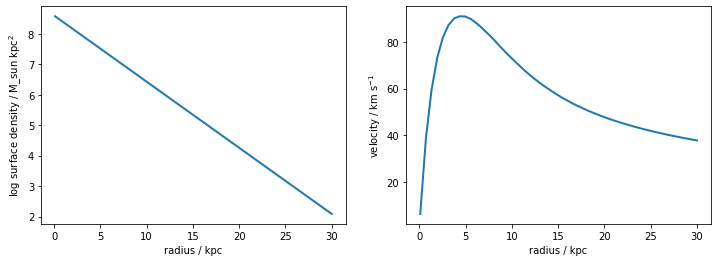

In [3]:
def plot_sb_vdisk(ax, r, sb, vdisk, label=None):
    ax[0].plot(r, np.log10(sb), lw=2)
    ax[0].set_xlabel("radius / kpc");
    ax[0].set_ylabel("log surface density / M_sun kpc"+"$^{2}$");

    ax[1].plot(r, vdisk, lw=2,  label=label)
    ax[1].set_xlabel("radius / kpc");
    ax[1].set_ylabel("velocity / km s"+"$^{-1}$");
    if label is not None: ax[1].legend()

fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sb_exp, vdisk)

We can explore how does $V_{\rm disk}$ change when changing the scaleheight of the disk $z_0$ for instance:

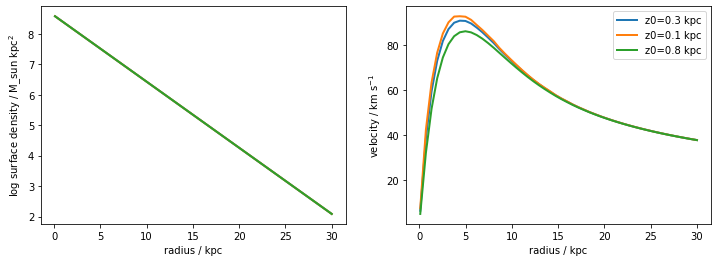

In [4]:
fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sb_exp, vdisk, label='z0=0.3 kpc')
plot_sb_vdisk(ax, r, sb_exp, vcdisk(r, sb_exp, z0=0.1), label='z0=0.1 kpc')
plot_sb_vdisk(ax, r, sb_exp, vcdisk(r, sb_exp, z0=0.8), label='z0=0.8 kpc')

### Sersic profile

Let's compare to other popular analytic surface density profiles. Probably the most used in Astronomy is the [Sersic (1968)](https://ui.adsabs.harvard.edu/abs/1968adga.book.....S) profile, which is often used to describe all sorts of stellar components, including disks and bulges.

In [5]:
def sersic(r, Ie, Re, n):
    bn = 2*n -1./3. +4./405./n # Ciotti & Bertin (1999): https://ui.adsabs.harvard.edu/abs/1999A%26A...352..447C/
    return Ie * np.exp(-bn * ((r/Re)**(1/n)-1))

Let's take as a reference the model:

In [6]:
sb_sers_disk = sersic(r, 0.743e8, 1.678*rd, 1.0)

which is equivalent to the exponential disk that we have above. Let's now compare the circular velocities of disks with Sersic surface brightnesses with different index $n$, while keeping the total luminosity fixed.

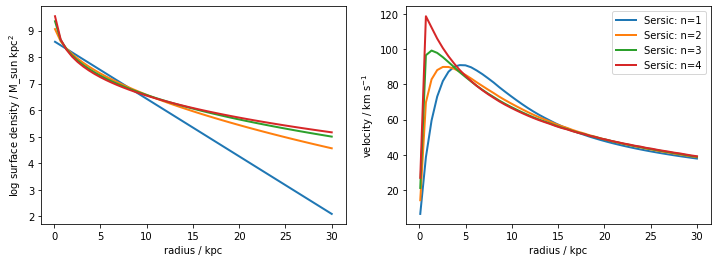

In [7]:
# here the profiles are renormalized to yield the same total mass = 1e10 Msun
# see e.g. Eq.(2) in Graham & Driver (2005): https://ui.adsabs.harvard.edu/abs/2005PASA...22..118G
sb_sers_n4 = sersic(r, 0.392e8, 1.678*rd, 4.0)
sb_sers_n3 = sersic(r, 0.449e8, 1.678*rd, 3.0)
sb_sers_n2 = sersic(r, 0.545e8, 1.678*rd, 2.0)

fig,ax = plt.subplots(figsize=(12,4), ncols=2)
plot_sb_vdisk(ax, r, sb_sers_disk, vcdisk(r, sb_sers_disk), label='Sersic: n=1')
plot_sb_vdisk(ax, r, sb_sers_n2, vcdisk(r, sb_sers_n2), label='Sersic: n=2')
plot_sb_vdisk(ax, r, sb_sers_n3, vcdisk(r, sb_sers_n3), label='Sersic: n=3')
plot_sb_vdisk(ax, r, sb_sers_n4, vcdisk(r, sb_sers_n4), label='Sersic: n=4')

## Example 2: observed surface brightness

Let's say that, instead of having just simple galaxy images from which we can derive an analytic approximation for the galaxy surface brightness, we have a detailed galaxy image from which we can measure the intensity in elliptical annuli. This is for instance the case of nearby galaxies such as [NGC 2403](http://cdsportal.u-strasbg.fr/?target=ngc2403), that I use here as an example.

I use data taken from the [SPARC](http://astroweb.cwru.edu/SPARC/) database for this galaxy, which I include in this package as the `NGC2403_rotmod.dat` file. Here are reported measurements of the intensity at 3.6$\mu$m taken with the *SPITZER* space telescope in elliptical annuli for this target.

In [8]:
rad, _, _, _, _, _, sb_n2403, _ = np.genfromtxt('NGC2403_rotmod.dat', unpack=True)
# convert SB to Msun / kpc^2
sb_n2403 *= 1e6

Now we can very easily use `vcdisk` to calculate $V_{\star, \rm disk}$ for this galaxy, and we can evena compare it to some analytic profiles.

/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


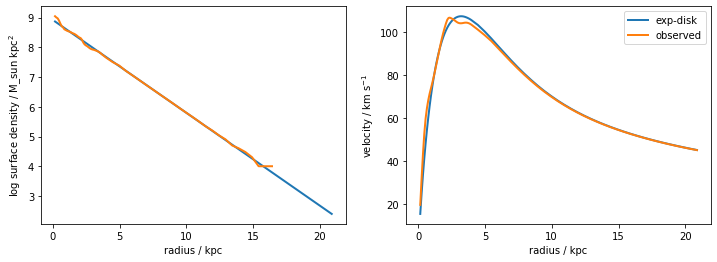

In [9]:
vd_n2403 = vcdisk(rad, sb_n2403, z0=0.4)       # z0=0.4 kpc from Fraternali et al. (2002): https://ui.adsabs.harvard.edu/abs/2002AJ....123.3124F
sb_exp_n2403 = expdisk_sb(rad, 1.004e10, 1.39) # numbers taken from http://astroweb.cwru.edu/SPARC/

fig,ax = plt.subplots(figsize=(12,4), ncols=2)

plot_sb_vdisk(ax, rad, sb_exp_n2403, vcdisk(rad, sb_exp_n2403), label='exp-disk')
plot_sb_vdisk(ax, rad, sb_n2403, vd_n2403, label='observed')

The $V_{\star, \rm disk}$ curve obtained with `vcdisk` directly from the ellipse photometry of NGC 2403 is much more structured between $1-5\rm \,kpc$, which is where the surface brightness has dips and peaks. 
*Capturing this rich structure is* **essential** *to rotation curve modelling*.